# Analysis of StableSwap Capital Efficiency, TUSD-USDC pair on Polygon, Curve.fi

We compute capital efficiency of the TUSD-USDC pair on Curve.fi (Polygon) compared to a concentrated liquidity pool. We use `[0.98, 1/0.98]` as the price range for concentrated liquidity pool. Note that the trading curve shape of the hypothetical concentrated liquidity pool does not matter for this particular calculation, though one would want a similar shape to StableSwap for other reasons.

On Curve.fi on Polygon, TUSD-USDC is traded in a "Meta Pool" with 4 assets, which is really a TUSD-3CRV pool (3CRV being LP shares of the DAI-USDC-USDT 3pool) that allows transparent trading through any of the asset pairs.

The first asset (TUSD) is special: This construction is *not* equivalent to a 4-asset StableSwap pool!

Note that we don't take any implementation details of Curve.fi into account, but instead model a system that represents the StableSwap curves exactly. We also ignore fees (which are irrelevant for our purposes here).

# Early Setup

Some code that has to run first

In [1]:
# Increase precision (from 53). Has to be the first thing in the file.
# (turns out to be unimportant for the result but we leave it in just to be sure)
RealNumber = RealField(300, sci_not=True)

In [2]:
load('stableswap.sage')

In [3]:
# Output helper:
def alln(*args):
    """x.n() or map over them."""
    if len(args) == 1:
        (x,) = args
        if isinstance(x, (list, tuple, set)):
            return type(x)(map(alln, x))
        return x.n()
    return tuple(alln(a) for a in args)

In [4]:
chain = 'polygon'  # ethereum or polygon. Sets parameters below.

We now first model the "Base" 3 pool. We then connect the two models.

# 3pool ("Base Pool") model

On Polygon:
- https://curve.fi/#/polygon/pools/aave/deposit
- LP token contract: https://polygonscan.com/address/0xE7a24EF0C5e95Ffb0f6684b813A78F2a3AD7D171#readContract

Note that the 3-pool on Polygon is an Aave pool that generates additional interest. This shouldn't matter for our computation and we don't model it.

On Ethereum, https://curve.fi/#/ethereum/pools/3pool/swap

The data snapshot is from 2022-11-28.

In [5]:
init_stableswap(3)

In [6]:
asset_labels_base = "DAI USDC USDT".split()

if chain == 'polygon':
    balances_base = [
        6259135935040567460324362/1e18,
        7412560976472/1e6,
        17433748160878/1e6,
    ]

    a_base_val = 2000

    # virtual price = invariant (d) / token supply.
    # Very similar to L/S for the "old" way of choosing CLP invariants in the Gyro pools.
    # (though we add a factor n, they use 1 upon initialization I think)
    # We can calculate this ourselves; only used for comparison
    virtual_price_base_pool = 1064420385548209601 / 1e18  # Pulled from contract

    # Pulled from LP share token contract.
    total_supply_base = 29221054903276675268850332 / 1e18
    
elif chain == 'ethereum':
    # Data hasn't been updated, may be slightly outdated
    balances_base = [
        139134531672192484052728700/1e18,
        130607117532366/1e6,
        399741984688542/1e6
    ]
    
    a_base_val = 2000
    
    virtual_price_base = 1022751574267137920/1e18
    
    total_supply_base = 654532899327680624513413100/1e18
    
else:
    raise ValueError("Unknown chain")

In [7]:
# Unscaled values
alln(balances_base)

[6.25913593504057e6, 7.41256097647200e6, 1.74337481608780e7]

In [8]:
d_base_sln = RealNumber(stableswap_get_d(balances_base, a_base_val))
d_base_sln.n()

3.11052273107122e7

In [9]:
# Sanity check: These should match
virtual_price_base_calcd = d_base_sln / total_supply_base
alln(virtual_price_base_pool, virtual_price_base_calcd)

(1.06442038554821, 1.06447995849815)

^^ They match but only *approximately*. This is likely due to implementation details on the Curve side. To keep things consistent with the virtual price, I re-calculate the virtual price based on these.

In [10]:
virtual_price_base = virtual_price_base_calcd

Now lets construct and solve the marginal trading equation.

In [11]:
# Replace everything that won't change and rename variables to avoid overlap
# with the meta pool.
# (scoping is kinda nonexistent in Sage)
y = var('y')
db = var('db')

eq_base_db_y = eq_stableswap.subs(
    d==db,
    t[0]==balances_base[0],
    t[1]==y,
    t[2]==balances_base[2],
    a==a_base_val
)

In [12]:
# y (= USDC amount) as a function of the invariant of the base pool (= db),
# equation form.
y_db_eq = solve(eq_base_db_y, y)[1]

In [13]:
# Sanity check: These should match.
y.subs(y_db_eq).subs(db==d_base_sln).n(), balances_base[1].n()

(7.41256097647206e6, 7.41256097647200e6)

# TUSD - 3CRV ("Meta Pool") model

On Polygon:
- https://curve.fi/#/polygon/pools/factory-v2-152/deposit

Raw (3CRV) balances must be pulled directly from the contract b/c the UI is completely transparent regarding the pool connection:
https://polygonscan.com/address/0xadf577b69eeac9df325536cf1af106372f2da263

On Ethereum, same pool:
- https://curve.fi/#/ethereum/pools/tusd/swap
- https://etherscan.io/address/0xecd5e75afb02efa118af914515d6521aabd189f1#readContract

*Note* that on Ethereum (but not on Polygon), TUSD-USDC can also be swapped using one of these two pools:
- https://curve.fi/#/ethereum/pools/y/swap (DAI-USDC-USDT-TUSD) - "Raw" (non-meta) pool wrapping yearn tokens. Operates transparently on wrapped amounts.
- https://curve.fi/#/ethereum/pools/factory-v2-144/swap (TUSD-FRAX-USDC) - Really a TUSD - (FRAX-USDC) metapool

I didn't study these alternative pools. (we could do this some other time)

The one I'm looking at here has by far the most TUSD in it.
Note that trading volumes through these pools (except the y pool) are really low, too.

In [14]:
init_stableswap(2)

In [15]:
asset_labels_meta = "TUSD 3CRV".split()

if chain == 'polygon':
    balances_meta = [
        4575351510086114492497250 / 1e18,
        5169501224126266578973344 / 1e18
    ]

    a_meta_val = 200
    
elif chain == 'ethereum':
    # Data hasn't been updated, may be slightly outdated
    balances_meta = [
        14488396098356162063943586/1e18,
        20906146815525945596347569/1e18
    ]
    
    a_meta_val = 600

else:
    raise ValueError("unkonwn chain")

alln(balances_meta)  # unscaled balances

[4.57535151008611e6, 5.16950122412627e6]

In [16]:
# The meta pool scales the LP shares by the virtual price (going from LP share space to D space)
# and then runs everything in D space. So we do the same here.
# Note that we don't need to scale the first component; this is only for decimal adjustment, which
# we don't need to handle.
# In the following, the t1 variable is always in D space (not LP share space).
from operator import mul
balances_meta_scaled = list(map(mul, balances_meta, [1, virtual_price_base]))
alln(balances_meta_scaled)

[4.57535151008611e6, 5.50283044851407e6]

In [17]:
# Share of total 3crv outstanding that are held by the meta pool
share_base_meta = (balances_meta[1] / total_supply_base)
share_base_meta.n()

0.176910150616999

In [18]:
# Linearity. These are the asset amounts shown in the transparent UI
# for the other three assets.
# Note that we can trade the TUSD in the pool against *more* than
# `corresp_balances_base[1]` USDC b/c we redeem the LP shares for *only* USDC,
# not a bundle of the three assets, for the trade we care about here.
corresp_balances_base = [t * share_base_meta for t in balances_base]
alln(corresp_balances_base)

[1.10730468100030e6, 1.31135727880535e6, 3.08420701295975e6]

In [19]:
d_meta_sln = RealNumber(stableswap_get_d(balances_meta_scaled, a_meta_val))
d_meta_sln.n()

1.00780746260390e7

In [20]:
# We also build the "marginal" curve on t[0], t[1] for the meta pool.
# Let's also rename t[0] to x (= TUSD)
var('x')
eq_meta = eq_stableswap.subs(
    d==d_meta_sln,
    a==a_meta_val,
    t[0]==x
)

In [21]:
# t1 as a function of x, equation form
t1_x_eq = solve(eq_meta, t[1])[1]

In [22]:
# Sanity check: These should match.
t[1].subs(t1_x_eq).subs(x==balances_meta_scaled[0]).n(), balances_meta_scaled[1].n()

(5.50283044851408e6, 5.50283044851407e6)

Let's now connect the two pools. Our invariant is:

1. The StableSwap invariant in the meta pool must hold (d = d_meta_sln being constant)

2. The StableSwap invariant in the base pool must hold (d = db being variable)

3. t1 1:1 maps to db in the base pool by burning/minting LP shares.

4. For the invariant curve, we reduce y by the maximum amount, y0, that can be redeemed by the pool. This doesn't change trades (b/c it's a constant shift) and ensures that the curve converges to y → 0 for x → ∞.

In [23]:
# Calculate db from t1. Recall that the meta pool only holds *some* of the LP tokens of the
# base pool. We convert the other LP shares to D space using the virtual price.
db_t1 = (1 - share_base_meta) * total_supply_base * virtual_price_base + t[1]

In [24]:
# Sanity check. These should match, respectively
alln(db_t1.subs(t[1]==balances_meta_scaled[1]), d_base_sln)

(3.11052273107122e7, 3.11052273107122e7)

# Connecting the two pools

In [25]:
# Now we put everything together by assuming that db == what we calculated
# above, and then calculate y from that.
y_db = y.subs(y_db_eq)
y_t1 = y_db.subs(db==db_t1)

In [26]:
y0 = y_t1.subs(t1==0)
y0.n()

1.91045223839366e6

In [27]:
# Here goes the constant shift.
y_corresp_t1 = y_t1 - y0
y_corresp_x = y_corresp_t1.subs(t1_x_eq)
y_x = y_corresp_x  # shorthand

In [28]:
# Sanity check, should match
alln(y_x.subs(x==balances_meta_scaled[0]), balances_base[1]-y0)

(5.50210873807840e6, 5.50210873807834e6)

For clarification, there are different ways of thinking about "pool size" on the 3CRV asset in the meta pool:

- `corresp_balances_base` = Assets we could get if we redeemed all the LP shares in the pool *proportionally for a mix* of the three base assets. We get *three* assets then!

- `balances_base[1] - y0` = USDC we could get if we redeemed all the LP shares in the pool *only for USDC*. **This is what we care about** for the *marginal* TUSD-USDC trading curve. This is close to, but not equal to `sum(corresp_balances_base)` b/c of (1) price impact while redeeming one-sided and (2) prices being not exactly 1 between the assets.

- `y0` is what's left in the 3pool if we did redeem all our LP shares for USDC only. This can be only relatively little, even if our own share of LP shares is somewhat small, because we use them (corresponding to a DAI-USDC-USDT mix) to only redeem for USDC. Note that `y0/balances_base[1]` also depends on the share of USDC compared to the other assets in the base pool (our LP shares being relatively more valuable when there's less USDC in the pool, which happens to be the case here; there's a price effect that goes in the other direction, but it's weak in the region we currently are).

For comparison:

In [29]:
alln(balances_base, corresp_balances_base, sum(corresp_balances_base), balances_base[1]-y0)

([6.25913593504057e6, 7.41256097647200e6, 1.74337481608780e7],
 [1.10730468100030e6, 1.31135727880535e6, 3.08420701295975e6],
 5.50286897276540e6,
 5.50210873807834e6)

In [30]:
# Share of the USDC in the 3pool that can be redeemed by us at most
alln((balances_base[1]-y0)/balances_base[1])

0.742268259990364

Since we have convinced ourselves that our y0 offset does the right thing, we can introduce the following shorthand for the effective vector of balances of the marginal TUSD-USDC curve:

In [31]:
# Shorthand
balances_marginal = [balances_meta[0], balances_base[1]-y0]

With the trading curve `y_x` constructed (see below for a plot btw), we can now easily get an analytical expression for the price of x denoted in units of y:

In [32]:
px_x = -y_x.diff()

In [33]:
# Sanity check: These should approximately match and yield a reasonable price, and it should be
# the price quoted by the pool (minus fees and implementation details)
pxy_now_approx = alln((balances_base[1]-y0)-y_x.subs(x==balances_meta[0]+1))
pxy_now_model = px_x.subs(x==balances_meta[0]).n()
alln(pxy_now_approx, pxy_now_model)

(1.00044334866107, 1.00044340712027)

# Capital Efficiency Computation

In [34]:
px_expd_range = (0.98, 1/0.98)

In [35]:
# Compute reserve values at the upper and lower price point
x_px_low = find_root(px_x==px_expd_range[0], 0, 1e8)
y_px_low = y_x.subs(x==x_px_low)
x_px_high = find_root(px_x==px_expd_range[1], 0, 1e8)
y_px_high = y_x.subs(x==x_px_high)

In [36]:
# For information
matrix([
    [x_px_low, y_px_low],
    balances_marginal,
    [x_px_high, y_px_high]
]).apply_map(lambda x: x.n())

[8.85684413773738e6 1.23741023337872e6]
[4.57535151008611e6 5.50210873807834e6]
[1.23195366961739e6 8.86206546651362e6]

**Capital efficiency result:**

In [37]:
px_now = pxy_now_model

The following shows the amount of assets inefficiently allocated in the pool. These are the assets that are currently in the pool and would never leave the pool if the price stays within our expected price range. Higher is worse. We express these in percent of current balances.

In [38]:
print(f"% TUSD reserved for prices > {px_expd_range[1]:.2f} = {(x_px_high/balances_marginal[0]*100):.2f} %")
print(f"% USDC reserved for prices < {px_expd_range[0]:.2f} = {(y_px_low/balances_marginal[1]*100).n():.2f} %")

% TUSD reserved for prices > 1.02 = 26.93 %
% USDC reserved for prices < 0.98 = 22.49 %


Interpretation i.t.o. portfolio value (at *current* prices):

In [39]:
# Numeraire = asset y = usdc
pfvalue_now = balances_marginal[0] * px_now + balances_marginal[1]
pfvalue_inefficient = x_px_high * px_now + y_px_low
pfvalue_inefficient_rel = pfvalue_inefficient / pfvalue_now
print(f"Portfolio value reserved for prices outside [{px_expd_range[0]:.2f}, {px_expd_range[1]:.2f}]: "+
      f"{pfvalue_inefficient.n():,.0f} (USDC) of {pfvalue_now.n():,.0f} (USDC) = {pfvalue_inefficient_rel.n()*100:.2f}%"
     )

Portfolio value reserved for prices outside [0.98, 1.02]: 2,469,910 (USDC) of 10,079,489 (USDC) = 24.50%


This is quite a lot. See the following section for some intuition.

# Plots / Intuition

We can plot the trading curve. Grid lines mark the points at the two ends of the price range.

Note that the following clearly *looks like* a StableSwap curve, but I'm not sure if it really is (more math needed). The left end of the curve is "shorter", but this could well be due to the way it's plotted (I'm plotting this as a function of x, so the two dimensions are not treated equally by the plotting algorithm).

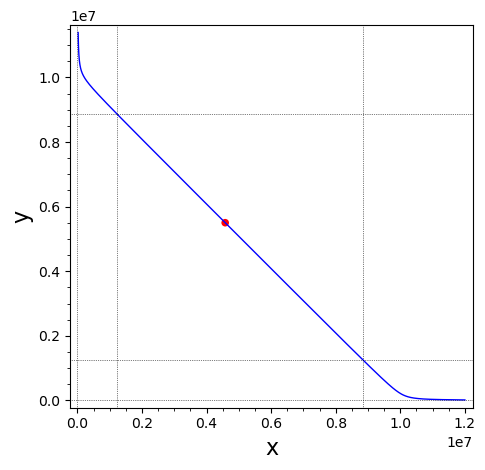

In [40]:
p1 = plot(y_x, x, 0, 1.2e7, aspect_ratio=1, axes=False, frame=True, ymin=0,
         gridlines=[[0, x_px_low, x_px_high],[0, y_px_low, y_px_high]],
         plot_points=500, adaptive_recursion=50,
         axes_labels=["x", "y"]
        )
# p2 = point((balances_meta_scaled[0], corresp_balances_base[1]), color="red", size=25)
p3 = point(balances_marginal, color="red", size=30)
show(p1 + p3)

It sure *seems* hard to believe that the capital inefficiency is so much. The curve looks really flat after all. Overall, this just seems to be because small price changes are very hard to visually see in the plot of the x-y curve. We instead plot the price as a function of x.

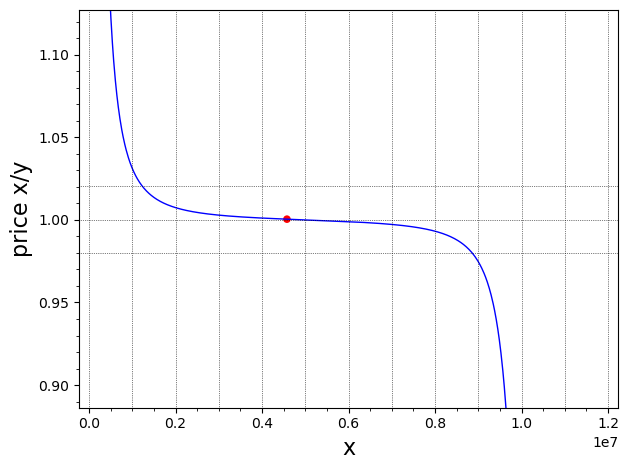

In [41]:
g = Graphics()
g += plot(px_x, x, 0, 1.2e7,
    ymin=px_expd_range[0]/1.1,
    ymax=px_expd_range[1]*1.1,
    gridlines=[[k * 1e7 for k in srange(0, 1.2, 0.1, include_endpoint=True)], [0,1]+list(px_expd_range)],
    axes_labels=["x", "price x/y"],
    axes=False, frame=True,
    plot_points=1000,
    adaptive_recursion=100,
)
g += point((balances_marginal[0], px_now), color="red", size=30)
show(g)

^^ We can visually see that the price leaves the relevant price range quite soon. We can see directly one half of the capital inefficiency, namely for asset x: at x≈0.125e7, the price is so high that it leaves the reasonable range. So these assets are never sold from the pool. As the current x balance is ≈0.457e7, this is on the order of 25% of current x assets that won't be used.

For the other half (asset y for the low price), we *can* see that this is reached relatively soon wrt. x, but to really be able to judge the extent of this effect we'd have to plot asset y with it. Or maybe do another y-px plot in addition to this x-px one.